In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv("digit-recognizer/train.csv")
test_data = pd.read_csv("digit-recognizer/test.csv")
submission = pd.read_csv("digit-recognizer/sample_submission.csv")


In [3]:
print(train_data.shape);train_data.head(5)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_data.drop("label", axis=1)
y_train = train_data.label

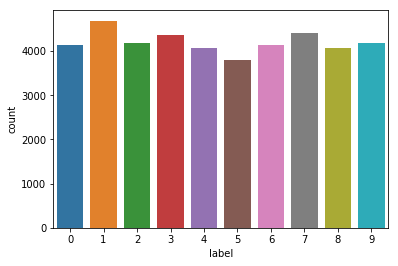

In [6]:
sns.countplot(y_train)

In [7]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
#grayscale normalization
X_train = X_train/255.
test_data = test_data/255.

In [9]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test_data = test_data.values.reshape(-1, 28, 28, 1)

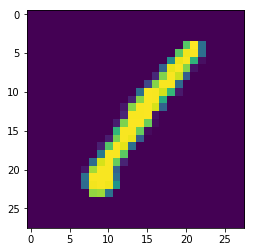

In [10]:
plt.imshow(X_train[0][:,:,0])

In [11]:
#encoding
y_train = to_categorical(y_train, num_classes=10); y_train.shape

(42000, 10)

In [12]:
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=420)

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, MaxPool2D, Dense
from keras.losses import categorical_crossentropy
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

In [15]:
optimizer = RMSprop(learning_rate=0.001)

In [49]:
model = Sequential()

model.add(Conv2D(filters=64, input_shape=(28,28,1), padding='Same', kernel_size=(5,5), activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.3))
model.add(Conv2D(filters=64,kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [50]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, min_lr=0.001)

In [51]:
history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=[X_val, y_val], callbacks=[reduce_lr])

Train on 34020 samples, validate on 3780 samples
Epoch 1/2
34020/34020 [==============================] - 363s 11ms/step - loss: 0.1576 - accuracy: 0.9504 - val_loss: 0.0424 - val_accuracy: 0.9876
Epoch 2/2
34020/34020 [==============================] - 347s 10ms/step - loss: 0.0426 - accuracy: 0.9874 - val_loss: 0.0370 - val_accuracy: 0.9886


In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
y_pred = model.predict(X_val, batch_size=8)

In [54]:
y_pred_argmax = np.argmax(y_pred, axis=1)

In [55]:
y_pred_argmax.shape

(3780,)

In [56]:
y_val.shape

(3780, 10)

In [57]:
y_val_argmax = np.argmax(y_val, axis=1)

In [58]:
y_val_argmax.shape

(3780,)

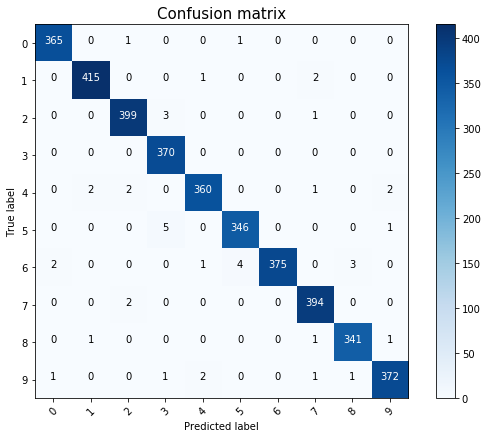

In [59]:
plt.figure(figsize=[8,6])
cm = confusion_matrix(y_pred_argmax, y_val_argmax)
plot_confusion_matrix(cm, classes=range(10))

In [61]:
results = model.predict(test_data, batch_size=8)

In [63]:
results_argmax = np.argmax(results, axis=1)
results_ = pd.Series(results_argmax, name='Label')

In [65]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results_],axis = 1)